# Hare and Lynx, Lotka-Volterra

The Lotka-Volterra model consists of a system of non-linear differential equations


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy.optimize as opt
from scipy.integrate import odeint
import os
from pathlib import Path

cwd = os.getcwd()


# Intepolate?
spline_flag = True

# Dataset definition
hare =  np.array([20, 20, 52, 83, 64, 68, 83, 12, 36, 150, 110, 60, 7, 10, 70, 100, 92, 70, 10, 11, 137, 137, 18, 22, 52, 83, 18, 10, 9, 65])
lynx =  np.array([32, 50, 12, 10, 13, 36, 15, 12, 6, 6, 65, 70, 40, 9, 20, 34, 45, 40, 15, 15, 60, 80, 26, 18, 37, 50, 35, 12, 12, 25])

dt = 2
t0 = 1845
t1 = 1904
t = np.arange(t0, t1, dt)
#t_train = np.reshape(t_train, (1,30))


def interpolation(t , hare, lynx, t_new):

    
    f_0 = interpolate.splrep(t, hare)
    f_1 = interpolate.splrep(t, lynx)

    hare_new = interpolate.splev(t_new, f_0)
    lynx_new = interpolate.splev(t_new, f_1)

    return hare_new, lynx_new

if spline_flag:

    #X_train = np.concatenate((np.array(hare),np.array(lynx)), axis=0).transpose()

    dt = 0.5
    t_train_new = np.arange(t0,t1,dt)
    hare, lynx = interpolation(t, hare, lynx, t_train_new)
    print(f"Interpolation used; dt = {dt}")
    t = t_train_new




# Directory for the images
image_dir = os.path.join(cwd, "Images")
Path(image_dir).mkdir(parents=True, exist_ok=True)

Interpolation used; dt = 0.5


In [2]:
# Defining the Lotka-volterra equations in a function

def lv(var, t, par):

    # Hare, prey
    x = var[0]

    # Lynx, predator
    y = var[1]

    b = par[0]
    p = par[1]
    r = par[2]
    d = par[3]

    dxdt = b * x - p * x * y
    dydt = r * x * y - d * y

    return [dxdt, dydt]


# Defining loss fucntion

def loss_fun(par, years, hare, lynx):

    # Initial condition
    y0 = [hare[0], lynx[0]]

    # evaluation points in time
    t = np.linspace(years[0], years[-1], num=len(years))

    out = odeint(lv, y0, t, args=(par,))

    loss = 0
    for i, _ in enumerate(years):

        # Loading actual data and predicted data by integrator
        data_hare = hare[i]
        model_hare = out[i, 0]
        data_lynx = lynx[i]
        model_lynx = out[i, 1]

        # residual computation
        res = (data_hare - model_hare)**2 + (data_lynx - model_lynx)**2

        # adding the loss
        loss += res

    return loss

/home/luca/tensorflow-env/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[0.88711906 0.03714455 0.00803054 0.3976968 ]


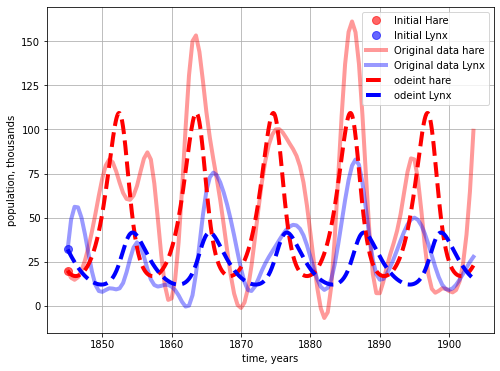

In [3]:
# Setting the inital guess for the optimizer

par0 = np.array([0.8, 0.3, 0.13, 2])
par_best = opt.fmin(loss_fun, par0, args=(t, hare, lynx)) 
# par0 = np.array([2, 0.2, 0.05, 1])
# opt_res = opt.minimize(loss_fun, par0, args=(t, hare, lynx))
# par_best = opt_res.x

print(par_best)

t_pred = np.linspace(t[0], t[-1], 500)

pred = odeint(lv, y0=[hare[0], lynx[0]], t=t_pred, args=(par_best,))

plt.figure(facecolor='white', figsize=(8, 6))

# Initial conditions
plt.plot(t0, hare[0], "ro", label="Initial Hare", alpha=0.6, markersize=8)
plt.plot(t0, lynx[0], "bo", label="Initial Lynx", alpha=0.6, markersize=8)

# Original Data
plt.plot(t, hare, "r", label="Original data hare", alpha=0.4, linewidth=4)
plt.plot(t, lynx, "b", label="Original data Lynx", alpha=0.4, linewidth=4)

# Predictions
plt.plot(t_pred, pred[:,0], "r--", label="odeint hare", linewidth=4)
plt.plot(t_pred, pred[:,1], "b--", label="odeint Lynx", linewidth=4)

plt.grid()
plt.xlabel("time, years")
plt.ylabel("population, thousands")
plt.legend()
plt.savefig(os.path.join(image_dir, "lv_fmin"))
plt.show()